In [13]:
import os
import json
import re
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass
from scipy.stats import pearsonr
def parse_jsonl(data):
    parsed_data = []
    for line in data:
        parsed_data.append(json.loads(line))

    return parsed_data

def get_main_df(path, file_in_question):

    main_df = pd.DataFrame()
    for root, dirs, files in os.walk(path):
        if "layer" not in root:
            continue

        for file in files:

            if file == file_in_question:
                with open(os.path.join(root, file)) as f:
                    data = f.readlines()


                parsed_data = parse_jsonl(data)
                df = pd.DataFrame(parsed_data)
                
                # We have tp, fp, tn, fn
                # We want precision, recall, f1
                df["precision"] = df["tp"] / (df["tp"] + df["fp"])
                df["recall"] = df["tp"] / (df["tp"] + df["fn"])
                df["f1"] = 2 * (df["precision"] * df["recall"]) / (df["precision"] + df["recall"])
                df["accuracy"] = (df["tp"] + df["tn"]) / (df["tp"] + df["tn"] + df["fp"] + df["fn"])
                df["layer"] = re.search(r"layer(\d+)", root).group(1)

                main_df = pd.concat([main_df, df])

    # reset index
    main_df = main_df.reset_index(drop=True)
    return main_df

def get_best(main_df, specific_layer:int=None):
    if specific_layer is not None:
        print(f"Filtering for layer {specific_layer}")
        main_df = main_df[main_df["layer"] == str(specific_layer)]
    best_accuracy = main_df[main_df["accuracy"] == main_df["accuracy"].max()]["accuracy"]
    best_f1 = main_df[main_df["f1"] == main_df["f1"].max()]["f1"]
    layer = main_df[main_df["f1"] == main_df["f1"].max()]["layer"]
    print(f"Best layer: {layer.values[0]}")
    # Sort main df by f1
    sorted_df = main_df.sort_values(by=["f1"], ascending=False)
    print(sorted_df.head(5))
    sorted_df = main_df.sort_values(by=["f1"], ascending=False)
    return best_accuracy, best_f1, sorted_df


# Define Metric structure
@dataclass
class Metric:
    name: str
    label: str


def get_correlation(main_df, 
                    x_col:str="n_features",
                    y_col:str="f1"):
    # Compute correlation
    correlation, p_value = pearsonr(main_df[x_col], main_df[y_col])
    return correlation, p_value

In [19]:
# Available metrics
F1 = Metric("f1", "F1 Score")
ACCURACY = Metric("accuracy", "Accuracy")
ACTIVE_METRIC = F1

@dataclass
class Model_topK_datasets:
    dataset_gbug_java_path: str
    dataset_defects4j_path: str
    dataset_humaneval_path: str


GPT2_ = Model_topK_datasets(
    dataset_gbug_java_path="gpt2_gbug-java",
    dataset_defects4j_path="gpt2_defects4j",
    dataset_humaneval_path="gpt2_humaneval"
)
# List of models/datasets
models = {
    "gpt2_gbug-java": GPT2_.dataset_gbug_java_path,
    "gpt2_defects4j": GPT2_.dataset_defects4j_path,
    "gpt2_humaneval": GPT2_.dataset_humaneval_path
}

GEMMA2_ = Model_topK_datasets(
    dataset_gbug_java_path="gemma2_gbug-java",
    dataset_defects4j_path="gemma2_defects4j",
    dataset_humaneval_path="gemma2_humaneval"
)


file_in_question = "random_forest.jsonl"

# Custom color palette inspired by the diagram
colors = {
    "gbug": "#d3dee3",         # Soft Blue-Grey
    "defects": "#fdf3d1",      # Light Yellow
    "humaneval": "#b8b09c"     # Neutral Grey
}
colors = {
    "gbug": "#a9bcc5",         # Slightly darker blue-grey
    "defects": "#f9e28b",      # Richer yellow
    "humaneval": "#8f8671"     # Deeper neutral
}

In [20]:

main_df = get_main_df(GPT2_.dataset_defects4j_path, file_in_question)
# sort by f1
main_df = main_df.sort_values(by=["f1"], ascending=False)
main_df = main_df[main_df["n_features"] <= 1000]
main_df

,classifier,n_features,tp,fp,tn,fn,y_pred,y_test,best_params,dataset,precision,recall,f1,accuracy,layer
164,random_forest,5,72,23,72,23,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","{'max_depth': 50, 'max_features': 'sqrt', 'min...",gpt2_defects4j/layer4/,0.757895,0.757895,0.757895,0.757895,4
2,random_forest,3,68,17,78,27,"[0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","{'max_depth': 50, 'max_features': 'sqrt', 'min...",gpt2_defects4j/layer11/,0.800000,0.715789,0.755556,0.768421,11
166,random_forest,20,72,26,69,23,"[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","{'max_depth': 50, 'max_features': 'sqrt', 'min...",gpt2_defects4j/layer4/,0.734694,0.757895,0.746114,0.742105,4
52,random_forest,5,68,20,75,27,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","{'max_depth': None, 'max_features': 'sqrt', 'm...",gpt2_defects4j/layer1/,0.772727,0.715789,0.743169,0.752632,1
129,random_forest,2,75,32,63,20,"[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","{'max_depth': None, 'max_features': 'sqrt', 'm...",gpt2_defects4j/layer2/,0.700935,0.789474,0.742574,0.726316,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,random_forest,1,52,20,75,43,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","{'max_depth': None, 'max_features': 'sqrt', 'm...",gpt2_defects4j/layer2/,0.722222,0.547368,0.622754,0.668421,2
176,random_forest,1,55,33,62,40,"[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","{'max_depth': 50, 'max_features': 'sqrt', 'min...",gpt2_defects4j/layer3/,0.625000,0.578947,0.601093,0.615789,3
64,random_forest,1,51,25,70,44,"[1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","{'max_depth': None, 'max_features': 'sqrt', 'm...",gpt2_defects4j/layer8/,0.671053,0.536842,0.596491,0.636842,8
96,random_forest,1,43,12,83,52,"[1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, ...","{'max_depth': None, 'max_features': 'sqrt', 'm...",gpt2_defects4j/layer0/,0.781818,0.452632,0.573333,0.663158,0


In [17]:


main_df = get_main_df(GEMMA2_.dataset_defects4j_path, file_in_question)
# Prepare heatmap dataframe
heat_map_df = pd.DataFrame(columns=["n_features"])
unique_layers = sorted([int(x) for x in main_df["layer"].unique()])
unique_layers = [str(x) for x in unique_layers]
unique_layers_n_features = sorted(main_df["n_features"].unique())
unique_layers_n_features = [x for x in unique_layers_n_features if x< 5000]

for layer in unique_layers:
    for n_features in unique_layers_n_features:
        layer_df = main_df[(main_df["layer"] == layer) & (main_df["n_features"] == n_features)]
        if not layer_df.empty:
            active_metric_value = layer_df[ACTIVE_METRIC.name].values[0]
            heat_map_df.loc[n_features, layer] = active_metric_value

heat_map_df["n_features"] = unique_layers_n_features
heat_map_df = heat_map_df.set_index("n_features")
print(f"Maximum value in heatmap: {heat_map_df.max().max()} in row {heat_map_df.max().idxmax()}")
heat_map_df

Maximum value in heatmap: 0.6016949152542372 in row 7


,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
n_features,,,,,,,,,,,,,,,,,,,,,
1,0.519774,0.474227,0.450549,0.446809,0.412371,0.559242,0.601695,0.575342,0.530233,0.459893,...,0.494949,0.486486,0.531915,0.521739,0.539326,0.425287,0.531915,0.529101,0.505051,0.413043
2,0.448276,0.461538,0.500000,0.444444,0.476684,0.544503,0.437500,0.474227,0.449198,0.459016,...,0.537313,0.505376,0.546392,0.518919,0.478261,0.497297,0.544503,0.484536,0.451613,0.500000
3,0.480447,0.458101,0.454054,0.378698,0.455026,0.446809,0.423913,0.480447,0.470588,0.438503,...,0.518519,0.524590,0.448276,0.569892,0.507772,0.494505,0.457447,0.408840,0.515464,0.500000
4,0.491979,0.491803,0.484536,0.406977,0.448087,0.465608,0.458333,0.448087,0.464865,0.476684,...,0.483871,0.543478,0.489583,0.480447,0.486486,0.529101,0.491803,0.524064,0.483871,0.468750
5,0.492147,0.483871,0.486486,0.418605,0.438202,0.510638,0.479167,0.455556,0.471264,0.522613,...,0.481283,0.522222,0.530000,0.513089,0.505495,0.500000,0.522167,0.537634,0.488636,0.472527
10,0.497238,0.517766,0.460674,0.469274,0.492308,0.502674,0.445714,0.534759,0.455556,0.488889,...,0.450549,0.479532,0.571429,0.471910,0.497238,0.483516,0.520833,0.502618,0.465116,0.494624
20,0.483871,0.502793,0.464088,0.448276,0.502513,0.481283,0.449704,0.554348,0.465909,0.494505,...,0.540541,0.537634,0.500000,0.511364,0.526316,0.471264,0.476190,0.463277,0.522222,0.465909
25,0.494382,0.494624,0.505376,0.467391,0.487310,0.459893,0.454545,0.524064,0.486486,0.502793,...,0.524590,0.497238,0.491620,0.474576,0.566845,0.491803,0.491228,0.461538,0.450867,0.480000
50,0.505376,0.537634,0.494505,0.459016,0.484211,0.478723,0.497175,0.529730,0.477273,0.472727,...,0.523256,0.524590,0.537634,0.491429,0.479042,0.453488,0.511364,0.433735,0.432749,0.510870


/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_22110/2061267438.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.94])


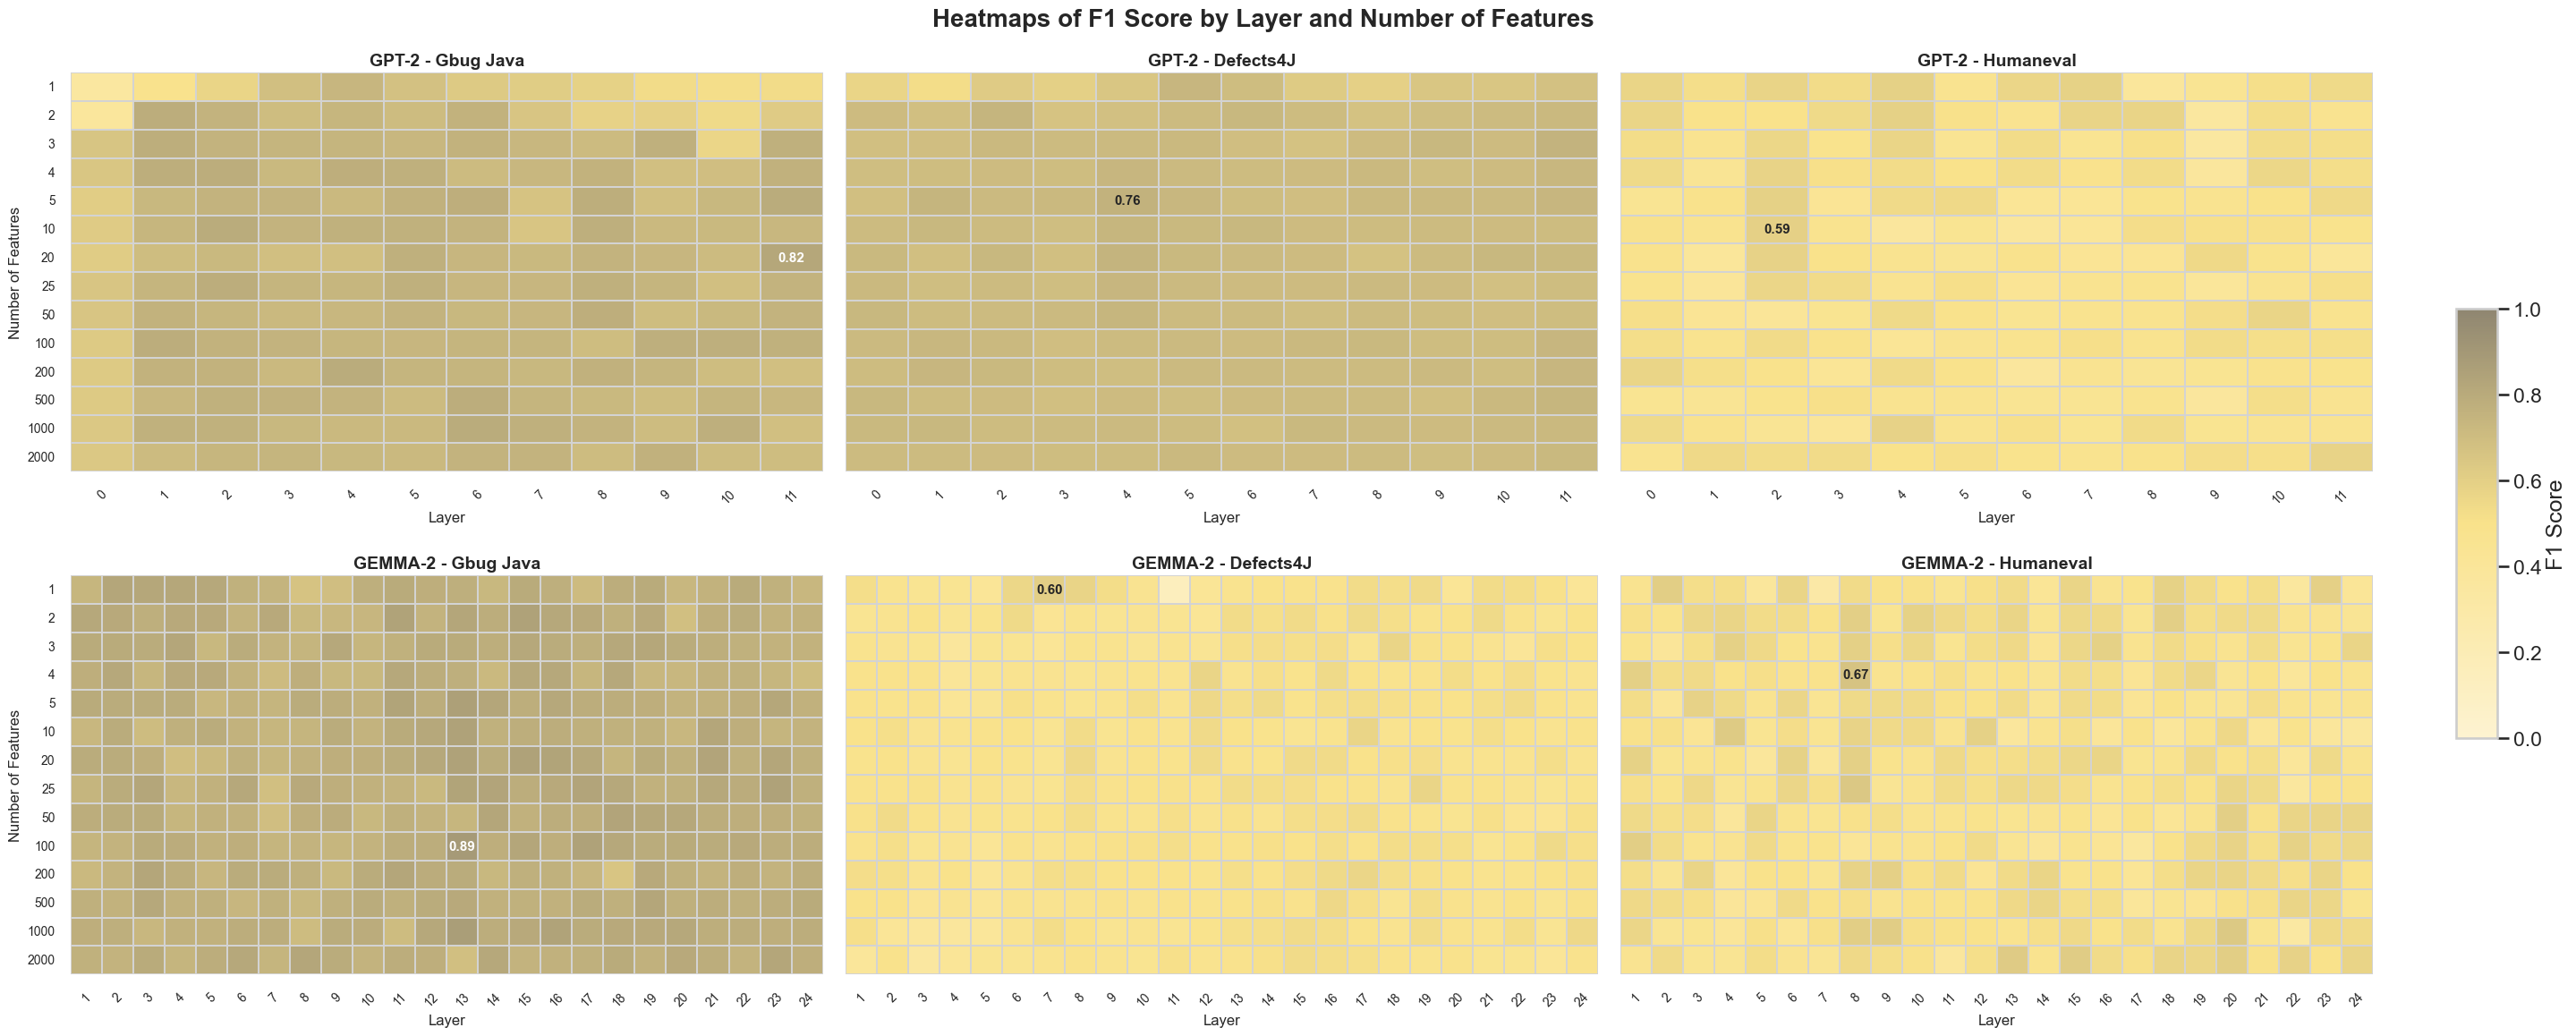

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormap
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_heatmap",
    ["#fdf3d1", "#f9e28b", "#8f8671"],
    
    N=256
)

# Combined model dictionary
all_models = {
    "GPT-2": {
        "gbug-java": GPT2_.dataset_gbug_java_path,
        "defects4j": GPT2_.dataset_defects4j_path,
        "humaneval": GPT2_.dataset_humaneval_path
    },
    "GEMMA-2": {
        "gbug-java": GEMMA2_.dataset_gbug_java_path,
        "defects4j": GEMMA2_.dataset_defects4j_path,
        "humaneval": GEMMA2_.dataset_humaneval_path
    }
}

# Set up the plot grid: 2 rows (GPT2, GEMMA2), 3 columns (datasets)
fig, axs = plt.subplots(2, 3, figsize=(31, 12), sharey=True)

# Placeholder for colorbar mappable
mappable = None

# Plotting
for row_idx, (model_family, models) in enumerate(all_models.items()):
    for col_idx, (dataset_name, model_path) in enumerate(models.items()):
        main_df = get_main_df(model_path, file_in_question)

        # Prepare heatmap dataframe
        heat_map_df = pd.DataFrame(columns=["n_features"])
        unique_layers = sorted([int(x) for x in main_df["layer"].unique()])
        unique_layers = [str(x) for x in unique_layers]
        unique_layers_n_features = sorted(main_df["n_features"].unique())
        unique_layers_n_features = [x for x in unique_layers_n_features if x< 5000]

        for layer in unique_layers:
            for n_features in unique_layers_n_features:
                layer_df = main_df[(main_df["layer"] == layer) & (main_df["n_features"] == n_features)]
                if not layer_df.empty:
                    if len(layer_df[ACTIVE_METRIC.name].values) > 1:
                        print(f"Warning: More than one value for {ACTIVE_METRIC.name} in layer {layer} and n_features {n_features}")
                    active_metric_value = layer_df[ACTIVE_METRIC.name].values[0]
                    heat_map_df.loc[n_features, layer] = active_metric_value

        heat_map_df["n_features"] = unique_layers_n_features
        heat_map_df = heat_map_df.set_index("n_features")

        # Draw heatmap
        # Find the maximum value position
        import numpy as np
        max_val = heat_map_df.values.max()
        max_pos = list(zip(*np.where(heat_map_df.values == max_val)))[0]
        max_n_features = heat_map_df.index[max_pos[0]]
        max_layer = heat_map_df.columns[max_pos[1]]
        max_val = heat_map_df.values.max()
        annot_df = heat_map_df.copy().astype(object)
        annot_df.loc[:, :] = ""  # Clear all annotations
        annot_df.loc[max_n_features, max_layer] = f"{max_val:.2f}"

        # Draw heatmap
        ax = axs[row_idx, col_idx]
        hm = sns.heatmap(
            heat_map_df,
            cmap=custom_cmap,
            annot=annot_df,
            fmt="",
            annot_kws={"size": 11, "weight": "bold"},
            linewidths=0.3,
            linecolor='lightgray',
            ax=ax,
            cbar=False,
            vmin=0,
            vmax=1,
        )

        if row_idx == 1 and col_idx == 2:
            mappable = hm.get_children()[0]

        # Titles and labels
        title = f"{model_family} - {dataset_name.replace('-', ' ').title()}"
        ax.set_title(title, fontsize=14, weight='bold')
        ax.set_xlabel("Layer", fontsize=12)
        if col_idx == 0:
            ax.set_ylabel("Number of Features", fontsize=12)
        else:
            ax.set_ylabel("")
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        for spine in ax.spines.values():
            spine.set_visible(False)

# External colorbar
cbar_ax = fig.add_axes([0.93, 0.3, 0.015, 0.4])
fig.colorbar(mappable, cax=cbar_ax, label=ACTIVE_METRIC.label)

# Final layout
plt.suptitle(f"Heatmaps of {ACTIVE_METRIC.label} by Layer and Number of Features", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 0.92, 0.94])
plt.subplots_adjust(left=0.07, right=0.9, top=0.92, bottom=0.08)
plt.show()

Best layer: 13
        classifier  n_features  tp  fp  tn  fn  \
281  random_forest         100  28   5  25   2   
276  random_forest           5  27   6  24   3   
241  random_forest           2  25   4  26   5   
73   random_forest         100  25   4  26   5   
231  random_forest          25  25   4  26   5   

                                                y_pred  \
281  [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...   
276  [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, ...   
241  [0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...   
73   [0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, ...   
231  [0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, ...   

                                                y_test  \
281  [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...   
276  [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...   
241  [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...   
73   [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...   
231  [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 

/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_22110/3798185865.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(
/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_22110/3798185865.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(
/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_22110/3798185865.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


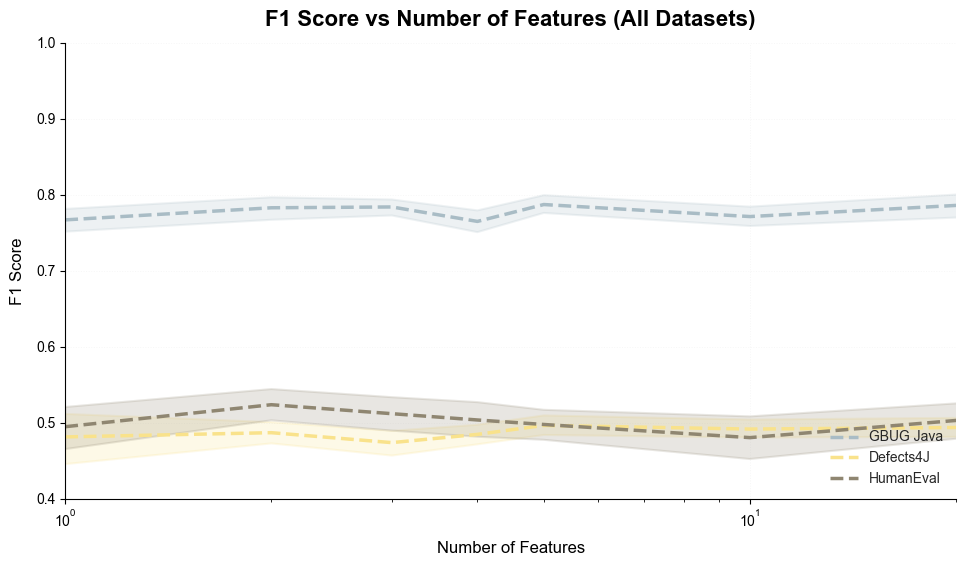

In [6]:

fig, ax = plt.subplots(figsize=(10, 6))

# Set Seaborn aesthetic theme
sns.set_theme(style="whitegrid", context="talk")

for label, path in models.items():
    main_df = get_main_df(path, file_in_question)
    # # Filter for specific layer if needed
    # main_df = main_df[main_df["layer"] == "0"]
    main_df = main_df[main_df["n_features"] <= 100]
    

    best_accuracy, best_f1, best_result = get_best(main_df)

    print(f"For {file_in_question} in {path}")
    print(f"BEST F1: {best_f1}")

    # Extract dataset key for color mapping
    if "gbug" in label:
        color = colors["gbug"]
        display_label = "GBUG Java"
    elif "defects" in label:
        color = colors["defects"]
        display_label = "Defects4J"
    elif "humaneval" in label:
        color = colors["humaneval"]
        display_label = "HumanEval"
    else:
        color = "#333333"
        display_label = label

    # Plot each dataset line on the same axis
    sns.lineplot(
        data=main_df,
        x="n_features",
        y=ACTIVE_METRIC.name,
        ci=95,
        label=display_label,
        color=color,
        linewidth=2.5,
        linestyle="--",
        ax=ax
    )

# Title and labels for shared plot
ax.set_title(
    f"{ACTIVE_METRIC.label} vs Number of Features (All Datasets)",
    fontsize=16,
    fontweight="bold",
    pad=12
)
ax.set_xlabel("Number of Features", fontsize=12, labelpad=8)
ax.set_ylabel(ACTIVE_METRIC.label, fontsize=12, labelpad=8)

# Log scale x-axis
ax.set_xscale("log")
ax.set_xlim(1, 20)
ax.set_ylim(0.4, 1)

# Ticks and style
ax.tick_params(labelsize=10)
ax.grid(True, which="major", linestyle=":", linewidth=0.7, alpha=0.1)
ax.legend(fontsize=10, loc="lower right", frameon=False)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()


In [ ]:

for label, path in models.items():
    main_df = get_main_df(path, file_in_question)
    print(get_correlation(main_df, x_col="n_features", y_col=ACTIVE_METRIC.name,
                    max_n_features=20))


In [ ]:


GPT2_ = Model_topK_datasets(
    dataset_gbug_java_path="gemma2_gbug-java",
    dataset_defects4j_path="gemma2_defects4j",
    dataset_humaneval_path="gemma2_humaneval"
)
# List of models/datasets
models = {
    "gemma2_gbug-java": GPT2_.dataset_gbug_java_path,
    "gemma2_defects4j": GPT2_.dataset_defects4j_path,
    "gemma2_humaneval": GPT2_.dataset_humaneval_path
}


file_in_question = "random_forest.jsonl"

# Custom color palette inspired by the diagram
colors = {
    "gbug": "#d3dee3",         # Soft Blue-Grey
    "defects": "#fdf3d1",      # Light Yellow
    "humaneval": "#b8b09c"     # Neutral Grey
}
colors = {
    "gbug": "#a9bcc5",         # Slightly darker blue-grey
    "defects": "#f9e28b",      # Richer yellow
    "humaneval": "#8f8671"     # Deeper neutral
}
fig, ax = plt.subplots(figsize=(10, 6))

# Set Seaborn aesthetic theme
sns.set_theme(style="whitegrid", context="talk")

for label, path in models.items():
    
    main_df = get_main_df(path, file_in_question)
    
    best_accuracy, best_f1, best_result = get_best(main_df)

    # print(f"For {file_in_question} in {path}")
    # print(f"BEST F1: {best_f1}")
    # print(f"BEST ACCURACY: {best_accuracy}")

    # Extract dataset key for color mapping
    if "gbug" in label:
        color = colors["gbug"]
        display_label = "GBUG Java"
    elif "defects" in label:
        color = colors["defects"]
        display_label = "Defects4J"
    elif "humaneval" in label:
        color = colors["humaneval"]
        display_label = "HumanEval"
    else:
        color = "#333333"
        display_label = label


    main_df[:1]
    # Plot each dataset line on the same axis
    sns.lineplot(
        data=main_df,
        x="n_features",
        y=ACTIVE_METRIC.name,
        ci=95,
        label=display_label,
        color=color,
        linewidth=2.5,
        linestyle="--",
        ax=ax
    )

# Title and labels for shared plot
ax.set_title(
    f"{ACTIVE_METRIC.label} vs Number of Features (All Datasets)",
    fontsize=16,
    fontweight="bold",
    pad=12
)
ax.set_xlabel("Number of Features", fontsize=12, labelpad=8)
ax.set_ylabel(ACTIVE_METRIC.label, fontsize=12, labelpad=8)

# Log scale x-axis
ax.set_xscale("log")
ax.set_xlim(1, 20)
ax.set_ylim(0.4, 1)

# Ticks and style
ax.tick_params(labelsize=10)
ax.grid(True, which="major", linestyle=":", linewidth=0.7, alpha=0.1)
ax.legend(fontsize=10, loc="lower right", frameon=False)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()


In [ ]:
for label, path in models.items():
    main_df = get_main_df(path, file_in_question)
    print(get_correlation(main_df, x_col="n_features", y_col=ACTIVE_METRIC.name,
                    max_n_features=20))